Iteration 1: Best Accuracy = 0.9591
Iteration 2: Best Accuracy = 0.9591
Iteration 3: Best Accuracy = 0.9591
Iteration 4: Best Accuracy = 0.9591
Iteration 5: Best Accuracy = 0.9591
Iteration 6: Best Accuracy = 0.9825
Iteration 7: Best Accuracy = 0.9825
Iteration 8: Best Accuracy = 0.9825
Iteration 9: Best Accuracy = 0.9825
Iteration 10: Best Accuracy = 0.9825
Iteration 11: Best Accuracy = 0.9825
Iteration 12: Best Accuracy = 0.9825
Iteration 13: Best Accuracy = 0.9825
Iteration 14: Best Accuracy = 0.9825
Iteration 15: Best Accuracy = 0.9825
Iteration 16: Best Accuracy = 0.9825
Iteration 17: Best Accuracy = 0.9825
Iteration 18: Best Accuracy = 0.9825
Iteration 19: Best Accuracy = 0.9825
Iteration 20: Best Accuracy = 0.9825
Iteration 21: Best Accuracy = 0.9825
Iteration 22: Best Accuracy = 0.9825
Iteration 23: Best Accuracy = 0.9825
Iteration 24: Best Accuracy = 0.9883
Iteration 25: Best Accuracy = 0.9883
Iteration 26: Best Accuracy = 0.9883
Iteration 27: Best Accuracy = 0.9883
Iteration 

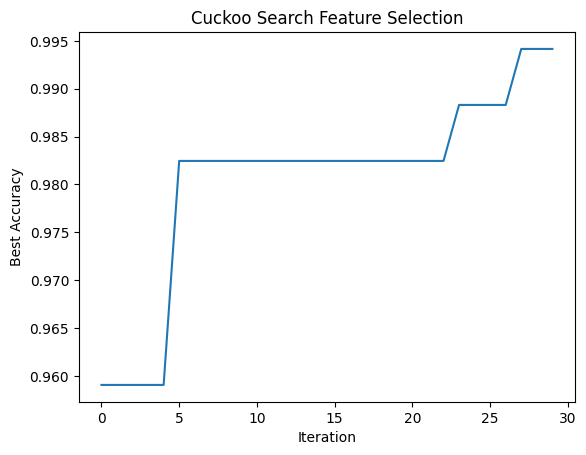

Best Accuracy: 0.9941520467836257
Selected Features: [ 0  4  5  6  9 11 13 15 16 17 19 23]


In [3]:
# Install dependencies (if running in Colab)
!pip install scikit-learn numpy matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.special import gamma  # <-- correct gamma function

# -----------------------------
#  Levy Flight function
# -----------------------------
def levy_flight(Lambda, size):
    sigma1 = (gamma(1+Lambda) * np.sin(np.pi*Lambda/2) /
              (gamma((1+Lambda)/2) * Lambda * 2**((Lambda-1)/2)))**(1/Lambda)
    u = np.random.normal(0, sigma1, size)
    v = np.random.normal(0, 1, size)
    step = u / (np.abs(v)**(1/Lambda))
    return step

# -----------------------------
#  Fitness Function: Accuracy
# -----------------------------
def fitness(solution, X_train, X_test, y_train, y_test):
    # Convert solution vector (0/1 mask) to features
    mask = solution > 0.5
    if np.sum(mask) == 0:  # avoid empty feature set
        return 0
    model = DecisionTreeClassifier()
    model.fit(X_train[:, mask], y_train)
    preds = model.predict(X_test[:, mask])
    return accuracy_score(y_test, preds)

# -----------------------------
#  Cuckoo Search Algorithm
# -----------------------------
def cuckoo_search(num_nests=20, max_iter=50, pa=0.25):
    # Load dataset
    data = load_breast_cancer()
    X_train, X_test, y_train, y_test = train_test_split(
        data.data, data.target, test_size=0.3, random_state=42
    )

    dim = X_train.shape[1]  # number of features
    nests = np.random.rand(num_nests, dim)  # initial population
    fitness_vals = np.array([fitness(n, X_train, X_test, y_train, y_test) for n in nests])

    best_idx = np.argmax(fitness_vals)
    best_sol, best_fit = nests[best_idx].copy(), fitness_vals[best_idx]

    history = []

    for t in range(max_iter):
        # Generate new solutions by Levy flight
        new_nests = nests + levy_flight(1.5, nests.shape) * (nests - best_sol)
        new_nests = np.clip(new_nests, 0, 1)  # keep within [0,1]

        # Evaluate new solutions
        new_fitness = np.array([fitness(n, X_train, X_test, y_train, y_test) for n in new_nests])

        # Replace if better
        for i in range(num_nests):
            if new_fitness[i] > fitness_vals[i]:
                nests[i] = new_nests[i]
                fitness_vals[i] = new_fitness[i]

        # Abandon some nests
        abandon = np.random.rand(num_nests, dim) < pa
        nests = np.where(abandon, np.random.rand(num_nests, dim), nests)

        # Update best solution
        best_idx = np.argmax(fitness_vals)
        if fitness_vals[best_idx] > best_fit:
            best_sol, best_fit = nests[best_idx].copy(), fitness_vals[best_idx]

        history.append(best_fit)
        print(f"Iteration {t+1}: Best Accuracy = {best_fit:.4f}")

    # Plot convergence
    plt.plot(history)
    plt.xlabel("Iteration")
    plt.ylabel("Best Accuracy")
    plt.title("Cuckoo Search Feature Selection")
    plt.show()

    # Return best result
    selected_features = np.where(best_sol > 0.5)[0]
    print("Best Accuracy:", best_fit)
    print("Selected Features:", selected_features)

# -----------------------------
# Run CSA
# -----------------------------
cuckoo_search(num_nests=20, max_iter=30, pa=0.25)
